# Project Title
### Data Engineering Capstone Project

#### Project Summary
--describe your project at a high level--

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql import SQLContext
from pyspark.sql.functions import isnan, when, trim, count, upper, col, udf, dayofmonth, dayofweek, month, year, weekofyear, desc
from pyspark.sql.functions import monotonically_increasing_id 
from pyspark.sql.types import *
from datetime import timedelta, datetime


### Step 1: Scope the Project and Gather Data

#### Project Summary
The aim of this project is to create a OLAP system to support Business Intelligence using
the datasets that are mentioned below. With the system created by this project, we can have an idea of how factors like demographics or temperature can have an affect on immigration to the US.

#### Scope

This project will use 4 datasets to, which are: <br>
* [I94 Immigration Data](https://www.trade.gov/national-travel-and-tourism-office) : This data comes from the US National Tourism and Trade Office. <br>
* [World Temperature Data](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data): This dataset came from Kaggle. <br>
* [U.S. City Demographic Data](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/): This data comes from OpenSoft. <br>
* [Airport Code Table](https://datahub.io/core/airport-codes#data): This is a simple table of airport codes and corresponding cities. <br>

Tools that are used: <br>
* AWS S3 for data storage
* Spark for big data processing
* Pandas for data wrangling

Step to complete the project: 
* Load data into pandas and spark for data exploratory analysis 
* Data cleaning on all tables: removing null values, duplicates 
* Create fact table
* Create dimension tables 
* Load fact and dimension tables into S3
* Copy data from S3 to Redshift 

### Describe and Gather data
<strong>I94 Immigration data </strong>: this data comes from National Travel and Tourism Office (NTTO), which provides statistic for travel and tourism industry. Form I-94 is the DHS Arrival/Departure Record issued to aliens who are admitted to the U.S., who are adjusting status while in the U.S. or extending their stay, among other things. A CBP officer gen- erally attaches the I-94 to the non-immigrant visi- tor's passport upon U.S. entry.The dataset comes from this I94 form <br>
<strong>World Temperature data</strong>: this data comes from Kaggle, it represents the global land temperatures by city  <br>
<strong>U.S City Demographic data</strong>: this dataset comes from the US Census Bureau's 2015 American Community Survey. It contains information about the demographics of all US cities and census-designated places with a population greater or equal to 65,000. <br>
<strong > Airport code table </strong>: This is a simple table of airport codes and corresponding cities. The airport codes may refer to either IATA airport code, a three-letter code which is used in passenger reservation, ticketing and baggage-handling systems, or the ICAO airport code which is a four letter code used by ATC systems and for airports that do not have an IATA airport code (from wikipedia)<br>

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

#### Immigration data

In [2]:
# Read in the data here
spark = SparkSession.builder\
                    .config("spark.jars.repositories", "https://repos.spark-packages.org/")\
                    .config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11")\
                    .config("spark.sql.broadcastTimeout", "-1")\
                    .enableHiveSupport()\
                    .getOrCreate()

immigration_df = spark.read.format('com.github.saurfang.sas.spark')\
                      .load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')


In [3]:
#write to parquet
# df_spark.write.parquet("sas_data")
immigration_df=spark.read.parquet("sas_data")
immigration_df.count()

3096313

In [4]:
immigration_df.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [5]:
def plot_null_count_sparkdf(df):
    # Getting null data
    null_df = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()
    null_df = null_df.T
    null_df.columns = ['null_counts']
    null_df['null_counts_pct'] = null_df['null_counts'] / df.count() * 100
    null_df['columns']= null_df.index
    
    # Plotting null data
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x='columns', y='null_counts_pct', data=null_df)
    ax.set_ylim(0, 100)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()

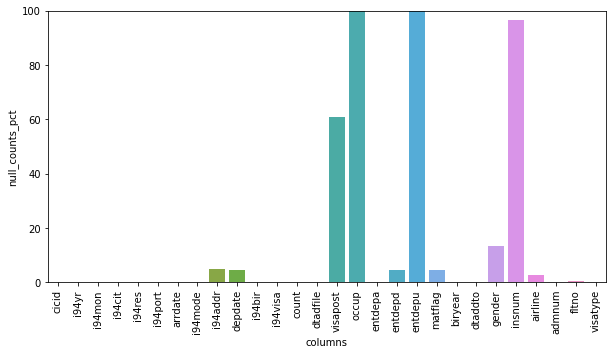

In [6]:
%matplotlib inline
plot_null_count_sparkdf(immigration_df)

In [7]:
# Data Cleaning for Immigartion df
# Drop the columns with more than 80% null values
drop_col_list = ['occup', 'entdepu','insnum']
immigration_df = immigration_df.drop(*drop_col_list)

In [8]:
immigration_df.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = true)
 |-- fltno: string (nullable = true)
 |-- visatype: string (nullable = true)



In [9]:
# Drop duplicate 
print(f'Number of records before dropping duplicate:{immigration_df.count()}')
immigration_df = immigration_df.dropDuplicates()
print(f'Number of records after dropping duplicate:{immigration_df.count()}')

Number of records before dropping duplicate:3096313
Number of records after dropping duplicate:3096313


In [10]:
# convert arrdate column to datetime 
@udf(TimestampType())
def convert_timestamp(arrdate):
    return (datetime(1960,1,1) + timedelta(days=int(arrdate)))
    
immigration_df = immigration_df.withColumn("arrdate", convert_timestamp(immigration_df.arrdate))

##### World Temeperature data

In [11]:
file_name = '../../data2/GlobalLandTemperaturesByCity.csv'
temperature_df = spark.read.csv(file_name, header=True, inferSchema=True)
temperature_df_temp = temperature_df.withColumn("dt",col("dt").cast(StringType())) # convert dt column type to string for visualization

In [12]:
temperature_df.count()

8599212

In [13]:
temperature_df.printSchema()

root
 |-- dt: timestamp (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



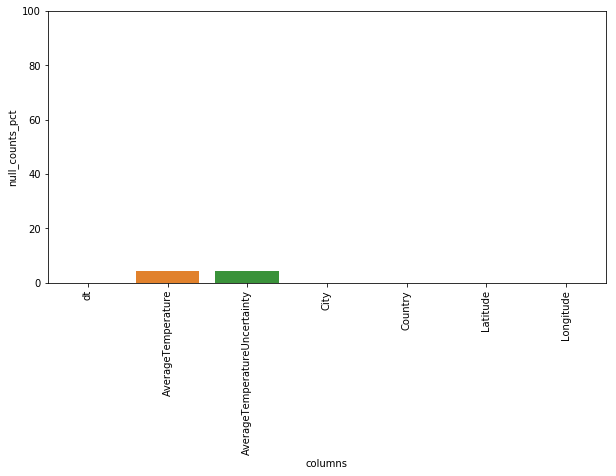

In [14]:
%matplotlib inline
plot_null_count_sparkdf(temperature_df_temp)

In [15]:
# Drop the null values from 2 columns AverageTemperature and AverageTemperatureUncertainty
drop_col_list = ['AverageTemperature', 'AverageTemperatureUncertainty']
temperature_df = temperature_df.dropna(how='any',subset=drop_col_list)

In [16]:
from pyspark.sql.functions import upper, col
temperature_df=temperature_df.select("*", upper(col('Country')))
temperature_df = temperature_df.withColumnRenamed('upper(Country)','country_name')
temperature_df.limit(5).toPandas()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,country_name
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E,DENMARK
1,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E,DENMARK
2,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E,DENMARK
3,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E,DENMARK
4,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E,DENMARK


In [17]:
# Drop duplicate 
print(f'Number of records before dropping duplicate:{temperature_df.count()}')
temperature_df = temperature_df.dropDuplicates()
print(f'Number of records after dropping duplicate:{temperature_df.count()}')

Number of records before dropping duplicate:8235082
Number of records after dropping duplicate:8235082


##### U.S. City Demographic Data

In [18]:
file_name = "us-cities-demographics.csv"
demographics_df = spark.read.csv(file_name, inferSchema=True, header=True, sep=';')
demographics_df.count()

2891

In [19]:
demographics_df.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: double (nullable = true)
 |-- Male Population: integer (nullable = true)
 |-- Female Population: integer (nullable = true)
 |-- Total Population: integer (nullable = true)
 |-- Number of Veterans: integer (nullable = true)
 |-- Foreign-born: integer (nullable = true)
 |-- Average Household Size: double (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: integer (nullable = true)



In [20]:
demographics_df.limit(5).toPandas()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


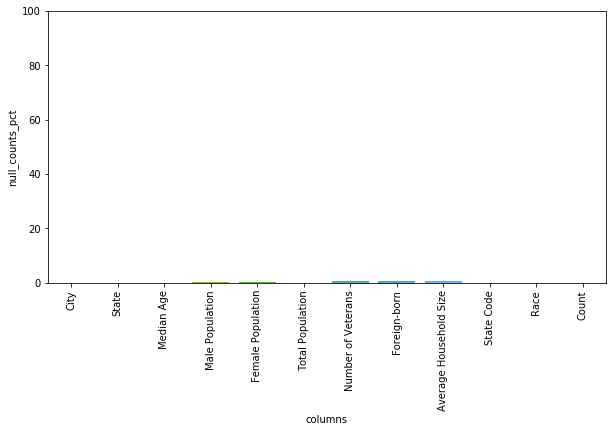

In [21]:
%matplotlib inline
plot_null_count_sparkdf(demographics_df)

##### Since demographic data don't have too many missing value, we don't have to drop any column

In [22]:
# Drop duplicate 
print(f'Number of records before dropping duplicate:{demographics_df.count()}')
demographics_df = demographics_df.dropDuplicates()
print(f'Number of records after dropping duplicate:{demographics_df.count()}')

Number of records before dropping duplicate:2891
Number of records after dropping duplicate:2891


#### Airport Code 


In [23]:
file_name = "airport-codes_csv.csv"
airport_code_df = spark.read.csv(file_name, inferSchema=True, header=True, sep=',')
airport_code_df.count()

55075

In [24]:
airport_code_df.printSchema()

root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: integer (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)



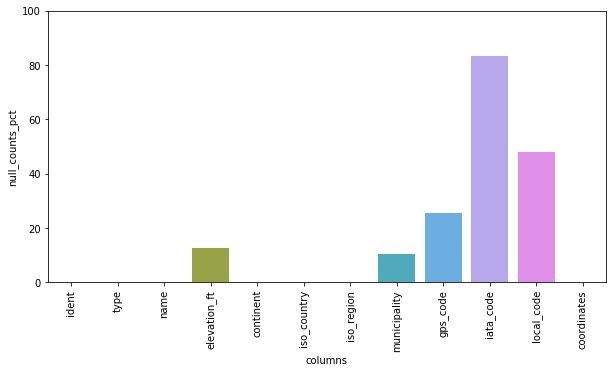

In [25]:
%matplotlib inline
plot_null_count_sparkdf(airport_code_df)

##### For airport code table, we need to drop the null for column iata_code, which will be used to map the data with the immigration data

In [26]:
# Drop the null values of columns iata_code 
airport_code_df = airport_code_df.dropna(how='any',subset=['iata_code'])

In [27]:
airport_code_df.printSchema()

root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: integer (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)



In [28]:
# Drop duplicate 
print(f'Number of records before dropping duplicate:{airport_code_df.count()}')
airport_code_df = airport_code_df.dropDuplicates()
print(f'Number of records after dropping duplicate:{airport_code_df.count()}')

Number of records before dropping duplicate:9189
Number of records after dropping duplicate:9189


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
We will use a star schema for this project because it is a great tool for an OLAP system and it is also very useful for Business Intelligence to find insights <br>
The data model consists of 1 Fact table Immigration and 4 Dimension tables (Demographics, Time, Temperature, Airport)


![Data Model](data_model.png)

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model
<ol>
  <li>Get data from source</li>
  <li>Clean data by dropping null columns and duplicates</li>
  <li>Transform data into fact and dimension tables</li>
  <li>Save file to S3</li>
  <li>Copy file from S3 to Redshift</li>

</ol>

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

#### Time Dimension 

In [29]:
time_dim_df = immigration_df.select(['arrdate'])
time_dim_df = time_dim_df.withColumn('arr_day', dayofmonth('arrdate'))
time_dim_df = time_dim_df.withColumn('arr_week', weekofyear('arrdate'))
time_dim_df = time_dim_df.withColumn('arr_month', month('arrdate'))
time_dim_df = time_dim_df.withColumn('arr_year', year('arrdate'))
time_dim_df = time_dim_df.withColumn('arr_weekday', dayofweek('arrdate'))

# create an id field in calendar df
time_dim_df = time_dim_df.withColumn('id', monotonically_increasing_id())

In [30]:
time_dim_df.limit(5).toPandas()

,arrdate,arr_day,arr_week,arr_month,arr_year,arr_weekday,id
0,2016-04-01,1,13,4,2016,6,0
1,2016-04-01,1,13,4,2016,6,1
2,2016-04-01,1,13,4,2016,6,2
3,2016-04-01,1,13,4,2016,6,3
4,2016-04-01,1,13,4,2016,6,4


##### Demographic Dimension

In [31]:
demographic_dim_df =  demographics_df.withColumnRenamed('Median Age','median_age') \
                                    .withColumnRenamed('Male Population', 'male_population') \
                                    .withColumnRenamed('Female Population', 'female_population') \
                                    .withColumnRenamed('Total Population', 'total_population') \
                                    .withColumnRenamed('Number of Veterans', 'number_of_veterans') \
                                    .withColumnRenamed('Foreign-born', 'foreign_born') \
                                    .withColumnRenamed('Average Household Size', 'average_household_size') \
                                    .withColumnRenamed('State Code', 'state_code')
# Add id column
demographic_dim_df = demographic_dim_df.withColumn('id', monotonically_increasing_id())

In [32]:
demographic_dim_df.limit(5).toPandas()

,City,State,median_age,male_population,female_population,total_population,number_of_veterans,foreign_born,average_household_size,state_code,Race,Count,id
0,Maple Grove,Minnesota,38.6,31780,36601,68381,2943,7645,2.64,MN,White,59683,0
1,Concord,California,39.6,62310,66358,128668,6287,37428,2.72,CA,White,92575,1
2,Highlands Ranch,Colorado,39.6,49186,53281,102467,4840,8827,2.72,CO,Asian,5650,2
3,Asheville,North Carolina,37.9,42100,46407,88507,4973,6630,2.18,NC,American Indian and Alaska Native,496,3
4,Westland,Michigan,39.9,37742,44253,81995,4756,6429,2.41,MI,Black or African-American,16422,4


#### Temperature Dimension 

In [33]:
with open('I94_SAS_Labels_Descriptions.SAS') as f:
    contents = f.readlines()

country_list = []
code_list = []
for countries in contents[10:298]:
    pair = countries.split('=')
    code, country = pair[0].strip(), pair[1].strip().strip("'")
    country_list.append(country)
    code_list.append(code)
country_code_df = {'code':code_list,'country':country_list}
country_code_df = pd.DataFrame(country_code_df)
temperature_df = temperature_df.withColumnRenamed('upper(Country)','country_name')
temperature_dim_table = temperature_df.select(['dt', 'AverageTemperature', 'AverageTemperatureUncertainty',\
                                               'City', 'country_name'])\
                                      .distinct()

temperature_dim_table = temperature_dim_table.select('*').groupby('country_name').avg()

temperature_dim_table = temperature_dim_table.withColumnRenamed('avg(AverageTemperature)', 'average_temperature')
temperature_dim_table = temperature_dim_table.withColumnRenamed('avg(AverageTemperatureUncertainty)', 'average_temperature_uncertainty')

@udf('string')
def get_country_code(name):
    if name.strip() in list(country_code_df['country']):
        code = country_code_df[country_code_df['country']==name.strip()]['code'].iloc[0]
        return code
    else:
        return '996'

temperature_dim_table = temperature_dim_table.withColumn("country_code", get_country_code(temperature_dim_table.country_name))
temperature_dim_table= temperature_dim_table.withColumn("country_code",temperature_dim_table.country_code.cast(IntegerType()))

temperature_dim_table = temperature_dim_table.withColumn('id', monotonically_increasing_id())

In [34]:
temperature_dim_table.limit(5).toPandas()

,country_name,average_temperature,average_temperature_uncertainty,country_code,id
0,SOUTH AFRICA,16.360849,0.724216,373,0
1,ARMENIA,8.375597,1.160792,151,1
2,BAHAMAS,24.786978,1.087271,512,2
3,BURMA,26.016840,0.880077,243,17179869184
4,CAMBODIA,26.918136,0.646212,996,51539607552


#### Airport code Dimension

In [35]:
airport_code_dim_table = airport_code_df.select('*')
# add an id column
airport_code_dim_table = airport_code_dim_table.withColumn('id', monotonically_increasing_id())
airport_code_dim_table.limit(5).toPandas()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates,id
0,AGAR,small_airport,Ulawa Airport,40.0,OC,SB,SB-MK,Arona,AGAR,RNA,None,"161.979546547, -9.86054358262",0
1,AGGN,small_airport,Nusatupe Airport,13.0,OC,SB,SB-WE,Gizo,AGGN,GZO,None,"156.863998413, -8.09778022766",1
2,AU-ZVG,small_airport,Springvale Airport,NaN,OC,AU,AU-WA,Springvale,None,ZVG,None,"127.66999816894531, -17.78689956665039",2
3,BZB,medium_airport,Bazaruto Island Airport,NaN,AF,MZ,MZ-I,Bazaruto Island,None,BZB,None,"35.4729, -21.5411",3
4,CN-0079,medium_airport,Shaoguan Guitou Airport,280.0,AS,CN,CN-44,Shaoguan,None,HSC,None,"113.42099762, 24.9785995483",4


#### Immigration Fact 

In [36]:
immigration_fact_table = immigration_df.withColumnRenamed('cicid','record_id') \
                                       .withColumnRenamed('i94res', 'country_residence_code') \
                                       .withColumnRenamed('i94addr', 'state_code') 
    
immigration_fact_table= immigration_fact_table.withColumn("country_residence_code",immigration_fact_table.country_residence_code.cast(IntegerType()))
immigration_fact_table.limit(5).toPandas()

,record_id,i94yr,i94mon,i94cit,country_residence_code,i94port,arrdate,i94mode,state_code,depdate,...,entdepa,entdepd,matflag,biryear,dtaddto,gender,airline,admnum,fltno,visatype
0,474.0,2016.0,4.0,103.0,103,NEW,2016-04-01,2.0,None,20547.0,...,G,O,M,1991.0,06292016,F,VES,5.541044e+10,91285,WT
1,1508.0,2016.0,4.0,104.0,104,NYC,2016-04-01,1.0,NY,20552.0,...,G,O,M,2000.0,06292016,F,LX,5.541641e+10,00016,WT
2,1669.0,2016.0,4.0,104.0,104,NYC,2016-04-01,1.0,FL,20561.0,...,G,O,M,1959.0,06292016,M,AA,5.545775e+10,00039,WT
3,2025.0,2016.0,4.0,104.0,104,NYC,2016-04-01,1.0,NY,20549.0,...,O,O,M,1965.0,06292016,None,SN,5.541998e+10,01401,WT
4,2048.0,2016.0,4.0,104.0,104,MIA,2016-04-01,1.0,FL,20554.0,...,O,O,M,2013.0,06292016,None,UX,5.545690e+10,00097,WT


#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [37]:
# Perform quality checks here
def data_count_check(df, table_name):
    """Count checks on fact and dimension table to ensure completeness of data.
        :param df: spark dataframe to check counts on
        :param table_name: corresponding name of table
        """
    total_count = df.count()

    if total_count == 0:
        print(f"Data count check failed for {table_name} with zero records!")
        return False
    else:
        print(f"Data count check passed for {table_name} with {total_count:,} records.")
        return True
    
def unique_key_check(df, unique_key_name, table_name):
    dupes = df.groupBy(unique_key_name).count().filter("count > 1")
    if dupes.count() == 0:
        print(f"Data quality pass for {table_name} with no duplicate on unique key column!")
        return True
    else: 
        print(f"Data quality failed for {table_name} with duplicate on unique key column!")
        return False

In [38]:
temperature_dimension_check = data_count_check (temperature_dim_table, 'Temperature Dimension Table') & \
                              unique_key_check(temperature_dim_table, 'id', 'Temperature Dimension Table')
temperature_dimension_check

Data count check passed for Temperature Dimension Table with 159 records.
Data quality pass for Temperature Dimension Table with no duplicate on unique key column!


True

In [39]:
# immigration_fact_check = data_count_check (immigration_fact_table, 'Immigration Fact Table') & \
#                          unique_key_check(immigration_fact_table, 'record_id', 'Immigration Fact Table')
# if immigration_fact_check: 
#     immigration_fact_table.write.parquet(output_path + "immigration_fact", mode="overwrite")

# time_dimension_check = data_count_check (time_dimension_table, 'Time Dimension Table') & \
#                        unique_key_check(time_dimension_table, 'id', 'Time Dimension Table')
# if time_dimension_check: 
#     partition_columns = ['arr_year', 'arr_month', 'arr_week']
#     time_dimension_table.write.parquet(output_path + "time_dimension", partitionBy=partition_columns, mode="overwrite")

# demographics_dimension_check = data_count_check (demographics_dimension_table, 'Demographics Dimension Table') &\
#                                unique_key_check(demographics_dimension_table, 'id', 'Demographics Dimension Table')

# if demographics_dimension_check:
#     demographics_dimension_table.write.parquet(output_path + "demographics_dimension", mode="overwrite")

# airport_code_check = data_count_check (airport_code_dimension_table, 'Airport Code Dimension Table') & \
#                      unique_key_check(airport_code_dimension_table, 'id', 'Airport Code Dimension Table')
# if airport_code_check: 
#     airport_code_dimension_table.write.parquet(output_path + "airport_code_dimension", mode="overwrite")

# temperature_dimension_check = data_count_check (temperature_dimension_table, 'Temperature Dimension Table') & \
#                               unique_key_check(temperature_dimension_table, 'id', 'Temperature Dimension Table')

# if temperature_dimension_check:
#     temperature_dimension_table.write.mode("overwrite").parquet(path=output_path + 'temperature_dimension')

#### 4.3 Data dictionary 
For each field in dimension and fact tables, I have provided a brief description of what the data is and where it came from. You can see it in the excel files within data_dictionary folder

#### Step 5: Complete Project Write Up


<ol>
  <li>Rationale for the choice of tools and technologies for the project.
  <ol>
      <li>Apache Spark: Spark has the ability to handle big data with very high speed. It offers a lightning-fast unified analytics engine for big data and it is very easy to use</li>
      <li>Amazon S3: S3 offers industry-leading scalability, data availability, security, and performance. You can use Amazon S3 to store and retrieve any amount of data at any time, from anywhere.</li>
      <li>Amazon Redshift: Redshift can handle huge volumes of data — capable of processing structured and unstructured data in the range of exabytes (1018 bytes). The service can also be used for large-scale data migrations. </li>
  </ol>
  </li>
  <li> How often the data should be updated and why
  <ol>
      <li>The data should be update on a monthly basis since the I94 data is updated every month</li>
   </ol>
   </li>
  <li>Write a description of how you would approach the problem differently under the following scenarios:
    <ol>
      <li>The data was increased by 100x.: Spark and S3 can handle the increased amount of data. We will need to increase the numbers of nodes for Spark cluster</li>
      <li>The data populates a dashboard that must be updated on a daily basis by 7am every day: We can use Airflow to schedule a DAG that runs on a daily basis at 7am</li>
      <li> The database needed to be accessed by 100+ people: Since the data is being stored in Amazon Redshift, we can manage the access for those people by creating policies on AWS to manage access for those people</li>
    </ol>
  </li>
</ol>

##### Example use of the database system

From the system that we have created, we can create a querry to test the relationship between the number of immigrant and time of the year, to see what most immigrants are arriving in which month.

![Data Model](data_model.png)|

In [42]:
immigration_fact_table = immigration_fact_table.persist()
time_dim_df = time_dim_df.persist()

In [ ]:
join_df = immigration_fact_table.join(time_dim_df,immigration_fact_table.arrdate == time_dim_df.arrdate,"left")\
                                .select(immigration_fact_table.arrdate,time_dim_df.arr_month)\
                                .groupBy("arr_month")\
                                .count()\
                                .withColumnRenamed("count","count_by_month")\
                                .sort(desc("count"))\
                                .limit(5).toPandas()